2024-07-18 18:45:40.044524: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-18 18:46:06.849660: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 18:46:19.374034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Matplotlib is building the font cache; this may take a moment.


Failed to load image: breast_ultrasound_images/Dataset_BUSI_with_GT/malignant/.ipynb_checkpoints
Images shape: (780, 128, 128, 3), dtype: float64
Masks shape: (780, 128, 128, 1), dtype: float64
Training samples: 624
Validation samples: 156


2024-07-18 18:46:53.774869: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 18:47:02.528329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-18 18:47:02.532206: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                             

2024-07-18 18:47:22.175359: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1721328465.614172    9946 service.cc:145] XLA service 0x7fd7dcf9b530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721328465.614209    9946 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-18 18:47:45.988760: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1721328466.779586    9946 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.9216 - dice_coefficient: 0.0987 - iou: 0.0526 - precision: 0.0885 - recall: 0.1684 - f1_score: 0.0987 - specificity: 0.8392 - sensitivity: 0.1684
Epoch 1: val_loss improved from inf to 0.24309, saving model to model-fcn.keras
78/78 [==============================] - 65s 207ms/step - loss: 0.3622 - accuracy: 0.9216 - dice_coefficient: 0.0987 - iou: 0.0526 - precision: 0.0885 - recall: 0.1684 - f1_score: 0.0987 - specificity: 0.8392 - sensitivity: 0.1684 - val_loss: 0.2431 - val_accuracy: 0.9225 - val_dice_coefficient: 0.1126 - val_iou: 0.0598 - val_precision: 0.1821 - val_recall: 0.0866 - val_f1_score: 0.1126 - val_specificity: 0.9686 - val_sensitivity: 0.0866 - lr: 1.0000e-04
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9216 - dice_coefficient: 0.1664 - iou: 0.0915 - precision: 0.1805 - recall: 0.1821 - f1_score: 0.1664 - specificity: 0.9268 - sensitivity: 0.1821
Ep

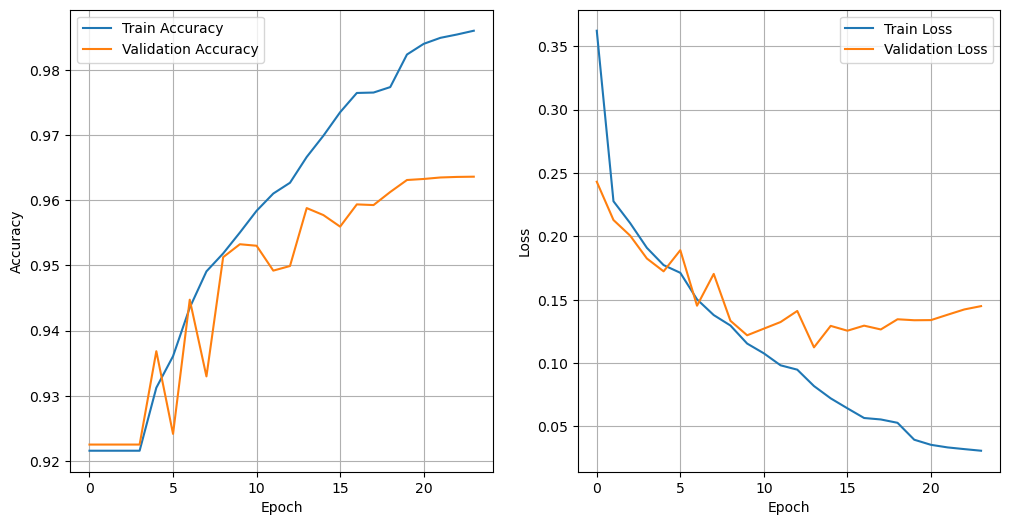

5/5 [==============================] - 7s 791ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a int64 tensor but is a float tensor [Op:AddV2] name: 

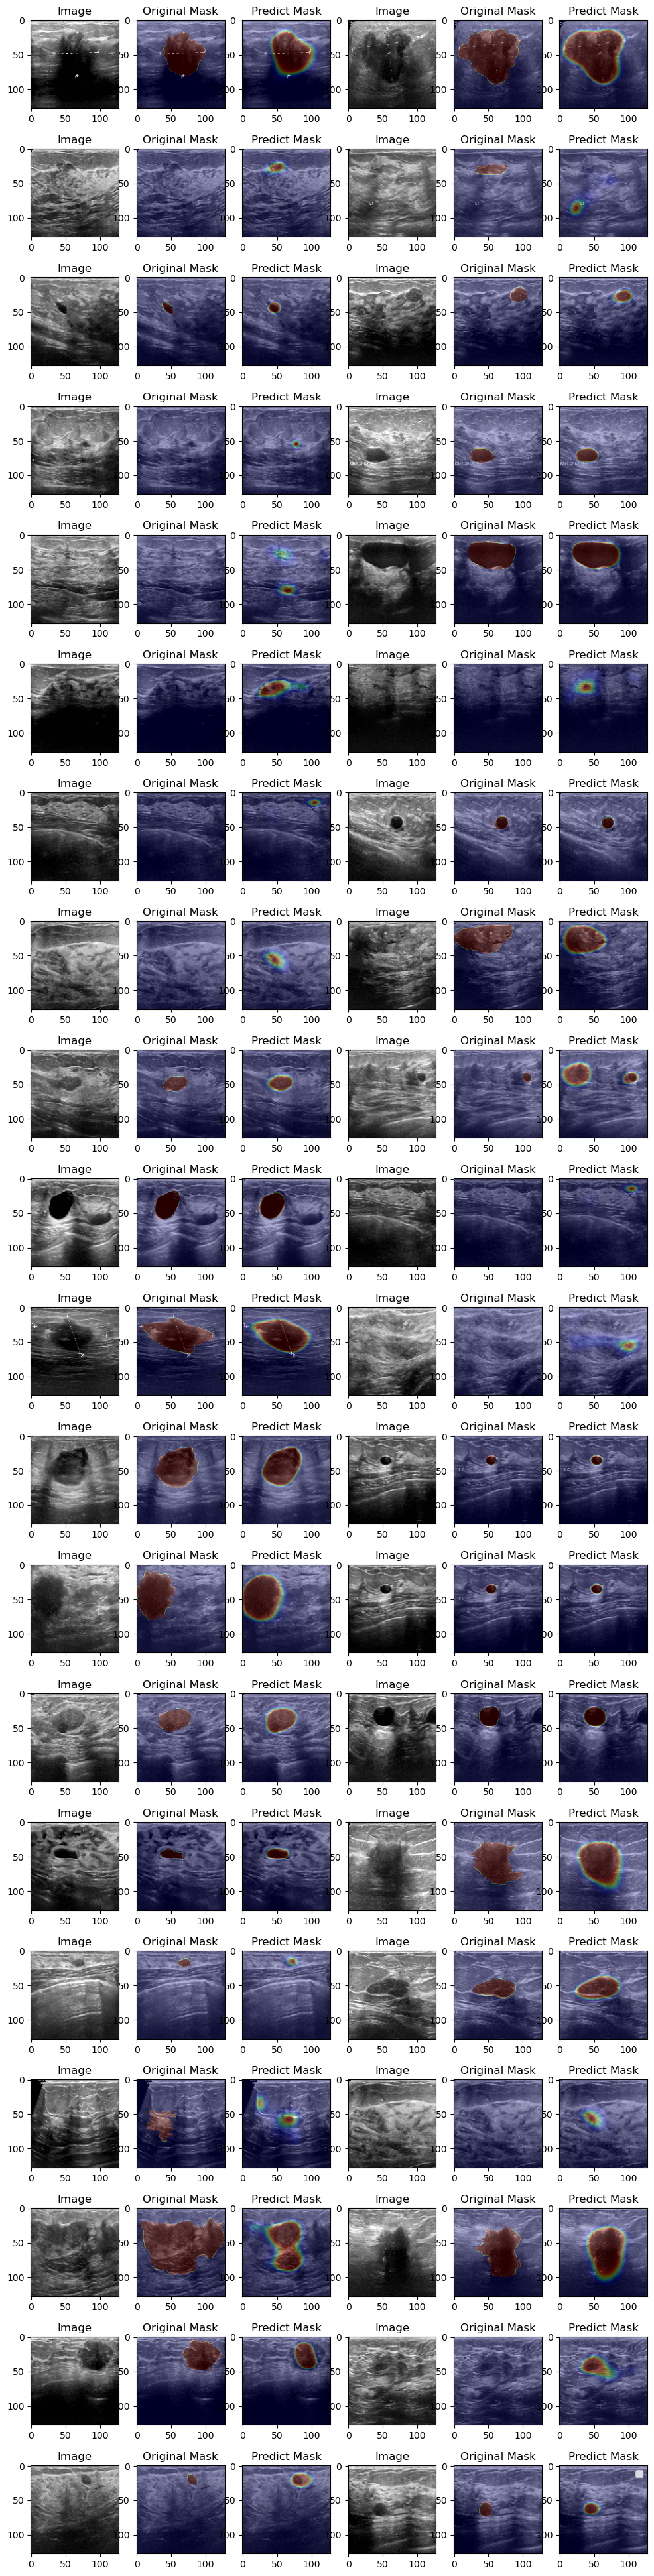

In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Load images and masks
def load_images_and_masks(base_data_dir, sub_dirs, img_size=(128, 128)):
    images = []
    masks = []
    
    for sub_dir in sub_dirs:
        data_dir = os.path.join(base_data_dir, sub_dir)
        
        if not os.path.exists(data_dir):
            print(f"Directory {data_dir} not found")
            continue
        
        files = sorted(os.listdir(data_dir))
        
        for file in files:
            if '_mask' in file:
                continue
            img_path = os.path.join(data_dir, file)
            mask_path = img_path.replace('.png', '_mask.png')
            
            # Load image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0, 1]
            
            # Load mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Failed to load mask: {mask_path}")
                continue
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize to [0, 1]
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
            
            images.append(img)
            masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load the images and masks from all subdirectories
dataset_dir = 'breast_ultrasound_images/Dataset_BUSI_with_GT'
sub_dirs = ['benign', 'malignant', 'normal']
images, masks = load_images_and_masks(dataset_dir, sub_dirs)

# Ensure correct shapes and types
print(f'Images shape: {images.shape}, dtype: {images.dtype}')
print(f'Masks shape: {masks.shape}, dtype: {masks.dtype}')

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f'Training samples: {X_train.shape[0]}')
print(f'Validation samples: {X_val.shape[0]}')

# Define the FCN model
def fcn_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    
    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[
        'accuracy', dice_coefficient, iou, precision, recall, f1_score, specificity, sensitivity])

    return model

# Define the metrics functions
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def iou(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + tf.keras.backend.epsilon()) / (union + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_positives = tf.reduce_sum(y_true_f * y_pred_f)
    predicted_positives = tf.reduce_sum(y_pred_f)
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_positives = tf.reduce_sum(y_true_f * y_pred_f)
    possible_positives = tf.reduce_sum(y_true_f)
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + tf.keras.backend.epsilon()))

def specificity(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    true_negatives = tf.reduce_sum((1 - y_true_f) * (1 - y_pred_f))
    possible_negatives = tf.reduce_sum(1 - y_true_f)
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def sensitivity(y_true, y_pred):
    return recall(y_true, y_pred)

# Build the FCN model
model = fcn_model()

# Display the model summary
model.summary()

# Define callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model-fcn.keras', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

# Save the final model
model.save('fcn_model.keras')

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Predict the masks for the validation data
y_pred_val = model.predict(X_val)

# Function to display images, masks, and predicted masks
def draw(images, masks, y_pred):
    plt.figure(figsize=(12, 50))
    index = -1
    n = np.random.randint(y_pred.shape[0])
    for i in range(120):
        plt.subplot(20, 6, (i + 1))
        if index == -1:
            plt.imshow(images[n])
            plt.title('Image')
            index = 0
        elif index == 0:
            plt.imshow(images[n])
            plt.imshow(masks[n], alpha=0.3, cmap='jet')
            plt.title('Original Mask')
            index = 1
        elif index == 1:
            plt.imshow(images[n])
            plt.imshow(np.reshape(y_pred[n], (128, 128)), alpha=0.3, cmap='jet')
            plt.title('Predict Mask')
            index = -1
            n = np.random.randint(y_pred.shape[0])
    plt.legend()

# Visualize some predictions
draw(X_val, y_val, y_pred_val)

# Calculate the metrics
masks_actual = (y_val > 0.5).astype(int).flatten()
masks_pred = (y_pred_val > 0.5).astype(int).flatten()

# Calculate the confusion matrix elements
tn, fp, fn, tp = confusion_matrix(masks_actual, masks_pred).ravel()

# Calculate the metrics
accuracy = accuracy_score(masks_actual, masks_pred) * 100
precision_val = precision_score(masks_actual, masks_pred) * 100
recall_val = recall_score(masks_actual, masks_pred) * 100
f1 = f1_score(masks_actual, masks_pred) * 100
specificity_val = (tn / (tn + fp)) * 100
dice_val = (2 * tp / (2 * tp + fp + fn)) * 100
sensitivity_val = (tp / (tp + fn)) * 100

# Display the metrics
metrics = pd.DataFrame([accuracy, precision_val, recall_val, f1, specificity_val, dice_val, sensitivity_val],
                       index=['Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'Specificity',
                              'Dice Score', 'Sensitivity'],
                       columns=['Metrics For Validation Data'])
print(metrics.head(n=8))


In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Predict the masks for the validation data
y_pred_val = (model.predict(X_val) > 0.5).astype(int)

# Flatten the arrays
masks_actual = y_val.flatten()
masks_pred = y_pred_val.flatten()

# Ensure both arrays are binary
masks_actual = (masks_actual > 0.5).astype(int)
masks_pred = (masks_pred > 0.5).astype(int)

# Calculate the confusion matrix elements
tn, fp, fn, tp = confusion_matrix(masks_actual, masks_pred).ravel()

# Calculate the metrics
accuracy = accuracy_score(masks_actual, masks_pred) * 100
precision_val = precision_score(masks_actual, masks_pred) * 100
recall_val = recall_score(masks_actual, masks_pred) * 100
f1 = f1_score(masks_actual, masks_pred) * 100
specificity_val = (tn / (tn + fp)) * 100
dice_val = (2 * tp / (2 * tp + fp + fn)) * 100
sensitivity_val = recall_val  # Sensitivity is the same as recall

# Display the metrics
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Dice Score', 'Sensitivity'],
    'Value': [accuracy, precision_val, recall_val, f1, specificity_val, dice_val, sensitivity_val]
})

print(metrics)


5/5 [==============================] - 0s 114ms/step
        Metric      Value
0     Accuracy  96.470720
1    Precision  82.759889
2       Recall  67.983516
3     F1 Score  74.647488
4  Specificity  98.828077
5   Dice Score  74.647488
6  Sensitivity  67.983516
